### makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length : how many characters do we take to predict the next one?
def build_dataset(words):
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)  
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80% training set
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% dev=validation set
Xte, Yte = build_dataset(words[n2:])      # 10% test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

seed_num = 2147483647
g = torch.Generator().manual_seed(seed_num)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size) ** 0.5 
b1 = torch.randn(n_hidden,generator=g) * 0.001
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01 # we want roughly zero at logits
b2 = torch.randn(vocab_size,generator=g) * 0 # at initialization, bias starts with 0, because we want roughly zero at logits.

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Caution

there are a number of modern innovations that have made everything significantly more stable and more well behaved,  
so it's become less important to initialize these networks exactly right(like a kaiming initialization).  

some of those modern innovations for example are,  
1. **residual connection**
2. **batch normalization**
3. **better optimizer**

### An intuitive understanding of weight changes    

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200) * 0.2
'''
what do i multiply by here to exactly preserve the standard deviation to be 1?
= 1 / math.sqrt(fan_in)

fan_in : 가중치 행렬로 들어오는 입력의 feature 개수
    ex) 위 코드의 경우, 입력 x (1000,10)의 feature는 10

위 아이디어에 기반한 가중치 초기화 방법이 Kaiming Initialization
'''

# w = torch.randn(10,200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)    
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)    
plt.hist(y.view(-1).tolist(), 50, density=True)

### 왜 표준편차를 1로 유지하는 것이 중요한가?

이것이 MLP(Multi-Layer Perceptron, 다층 퍼셉트론)에서 정말 중요한 개념이다.   
**신호(데이터)가 신경망의 여러 층을 통과할 때 그 세기를 일정하게 유지하기 위해서**라고 생각하면 쉽다.

마치 '스무고개'나 '전화 게임'을 하는 것과 비슷하다.  

**Vanishing Gradients**:   
첫 번째 사람이 속삭이듯 말하면, 다음 사람은 더 작게 말하고, 맨 끝 사람은 아무것도 듣지 못한다.   
신경망에서도 마찬가지다. 층을 거칠수록 신호(데이터의 분산/표준편차)가 계속 작아지면, 결국 신호가 사라져 버린다. 이는 역전파(backpropagation) 시 기울기(gradient)가 0에 가까워져 가중치 업데이트가 거의 일어나지 않는 "기울기 소실(Vanishing Gradients)" 문제로 이어진다. 모델이 학습을 못 하게 되는 것이다.  

**Exploding Gradients**:  
반대로 첫 번째 사람이 소리를 지르면, 다음 사람은 더 크게 소리 지르고, 맨 끝에서는 귀가 아플 정도로 소리가 커진다  
신경망에서도 층을 거치며 신호가 계속 커지면, 값이 기하급수적으로 폭주하게 된다. 이는 기울기가 비정상적으로 커지는 "기울기 폭주(Exploding Gradients)" 문제로 이어져 학습이 불안정해지고 발산하게 된다.  

핵심은 각 층을 통과한 후에도 데이터의 표준편차를 입력과 비슷한 수준(예: 1)으로 유지해서, 
신호가 너무 약해지거나 너무 강해지지 않고 안정적으로 전달되도록 하는 것이다.  

## batch normalization

@ normalization이란 무엇인가?  

데이터를 표준분포로 만드는 것을 표준화라고 한다.  
각 데이터에 평균을 빼고,  
표준편차로 나눈다.

@@ batch normalization이란 무엇인가?

1. 미니배치(Mini-batch)의 평균과 분산 계산
학습 데이터를 한 번에 모두 처리하는 대신, 작은 묶음인 '미니배치' 단위로 나누어 처리한다.   배치 정규화는 이 미니배치에 포함된 데이터들의 평균(μ)과 분산(σ²)을 계산한다.

2. 정규화 (Normalization)
각 데이터에서 방금 구한 평균을 빼고, 표준편차(분산의 제곱근)로 나누어준다. 
이렇게 하면 데이터가 평균 0, 표준편차 1에 가까운 '표준' 분포로 재배치된다.  
데이터가 너무 크거나 작아지는 것을 막아주어 학습을 안정시킨다.  

@@@ batch normalization에 대한 특징  

단기적으로는 비용이 많이 든다.  
- 계산량(평균, 분산) 증가, 병렬 연산 추가

장기적으로는 효율적이다.
- 높은 학습률, 안정적인 훈련
- 더 적은 에포크로 동일한 성능 도달, 즉 개별 연산은 느리나, 전체 훈련 시간이 단축.

In [38]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [39]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # bias doing nothing here. because after batch normalization, we substracted out `bnmeani`.
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True) 
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1942
  20000/ 200000: 2.3443
  30000/ 200000: 2.4160
  40000/ 200000: 1.9913
  50000/ 200000: 2.2978
  60000/ 200000: 2.5254
  70000/ 200000: 2.0707
  80000/ 200000: 2.3107
  90000/ 200000: 2.0663
 100000/ 200000: 1.9933
 110000/ 200000: 2.3179
 120000/ 200000: 1.9123
 130000/ 200000: 2.4505
 140000/ 200000: 2.4321
 150000/ 200000: 2.2003
 160000/ 200000: 2.0463
 170000/ 200000: 1.8839
 180000/ 200000: 1.9983
 190000/ 200000: 1.8873


### problem 1 : at initialization, softmax confidently wrong

In [14]:
# at initialization, uniform distribution , (a-z) alphabet.
-torch.tensor(1/27.0).log()

# but at the start, loss starts with 
# '0/ 200000: 27.8817'
# it means at starting, the neural net is creating probability distributions that are all messed up, some character is confident, and some character is not.

# so basically what's happening right is that the network is very confidently wrong.

'''
# 4-dimensional example of the issue
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss =  -probs[2].log()
probs, loss
'''

# 27-dimensional example of the issue
logits = torch.zeros(27).float()
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370]),
 tensor(3.2958))

### problem 2 : vector 'h', gradient vanishing

In [22]:
h

tensor([[ 0.5632, -0.0976, -0.6660,  ..., -0.3502, -0.9751,  0.8870],
        [-0.9048, -0.1838, -0.1835,  ...,  0.0467,  0.5026,  0.4357],
        [ 0.8082,  0.1261,  0.8236,  ...,  0.2865,  0.6541,  0.8816],
        ...,
        [-0.9161,  0.5273, -0.0349,  ..., -0.0857,  0.8688,  0.8838],
        [-0.9338,  0.1018, -0.2813,  ..., -0.1287,  0.7916,  0.9094],
        [-0.9161,  0.5273, -0.0349,  ..., -0.0857,  0.8688,  0.8838]],
       grad_fn=<TanhBackward0>)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  41.,  74.,  65.,  99., 136., 168., 185., 220., 224., 271.,
        311., 309., 356., 369., 380., 361., 361., 334., 294., 282., 284.,
        249., 186., 169., 134., 104.,  82.,  74.,  42.,  29.,  28.,  19.,
         12.,   7.,  12.,   3.,   2.,   7.]),
 array([-3.76140118, -3.61777295, -3.47414472, -3.33051649, -3.18688826,
        -3.04326003, -2.8996318 , -2.75600357, -2.61237534, -2.46874711,
        -2.32511888, -2.18149065, -2.03786242, -1.89423419, -1.75060596,
        -1.60697773, -1.46334949, -1.31972126, -1.17609303, -1.0324648 ,
        -0.88883657, -0.74520834, -0.60158011, -0.45795188, -0.31432365,
        -0.17069542, -0.02706719,  0.11656104,  0.26018927,  0.4038175 ,
         0.54744573,  0.69107396,  0.83470219,  0.97833042,  1.12195865,
         1.26558688,  1.40921511,  1.55284334,  1.69647157,  1.8400998 ,
         1.98372803,  2.12735626,  2.27098449,  2.41461272,  2.55824095,
 

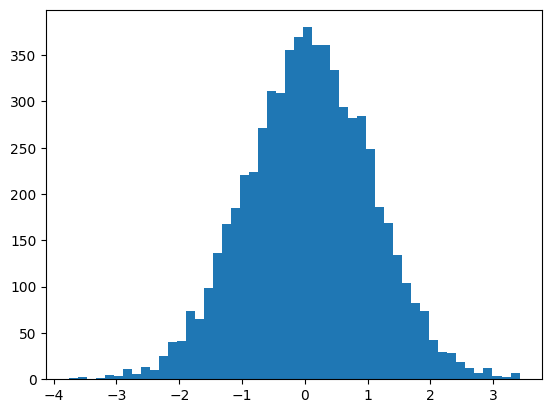

In [23]:
plt.hist(hpreact.view(-1).tolist(), bins = 50)


tanh 함수를 통과하면서 각각 1.0 또는 -1.0에 매우 가까운 값으로 바뀌는데, 넓은 범위의 입력값들이 모두 이 좁은 출력 범위로 '압축(squashed)되고 있다.  

이는 기울기가 소실되어버리는 현상으로 이어지는데, tanh의 그래프 개형이 1, -1에 가까워질수록 기울기가 점차 0에 가까워지기 때문이다.
기울기가 0에 가까워진다는 말은 변화율이 0에 수렴한다는 뜻이고, 
변화율이 0에 수렴한다는 것은 거의 안 변한다, 변화율이 미미하다는 뜻이다.   

즉, 이는 넓은 범위의 입력값들이 좁은 출력 범위로 압축되어 1, -1로 몰리면서, 엄청난 차이를 가진 값들이, 상대적으로 매우 미미한 차이로 좁혀지는 squashed 된다는 점에서 일맥상통하다.  

이처럼 출력이 극단적인 값에 가까워지는 영역을 포화(saturation) 영역이라고 한다.

(array([140., 172., 169., 160., 144., 154., 134., 129., 109., 140.,  94.,
        102., 131., 110., 118.,  95.,  83.,  99., 104., 102., 110., 123.,
        111.,  73., 105., 113., 103., 103., 102.,  96., 103., 122., 115.,
        125.,  90., 144., 103., 101., 121., 123., 140., 121., 170., 164.,
        161., 184., 186., 197., 212., 190.]),
 array([-9.98919368e-01, -9.58983738e-01, -9.19048109e-01, -8.79112480e-01,
        -8.39176850e-01, -7.99241221e-01, -7.59305592e-01, -7.19369962e-01,
        -6.79434333e-01, -6.39498703e-01, -5.99563074e-01, -5.59627445e-01,
        -5.19691815e-01, -4.79756186e-01, -4.39820557e-01, -3.99884927e-01,
        -3.59949298e-01, -3.20013669e-01, -2.80078039e-01, -2.40142410e-01,
        -2.00206780e-01, -1.60271151e-01, -1.20335522e-01, -8.03998923e-02,
        -4.04642630e-02, -5.28633595e-04,  3.94069958e-02,  7.93426251e-02,
         1.19278255e-01,  1.59213884e-01,  1.99149513e-01,  2.39085143e-01,
         2.79020772e-01,  3.18956401e-01,  3.58892

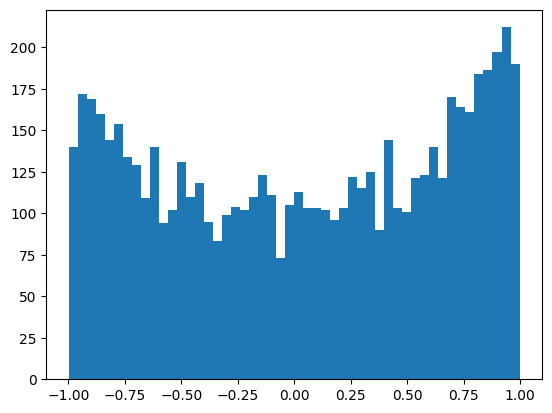

In [24]:
plt.hist(h.view(-1).tolist(), bins = 50)

In [12]:
h.shape

torch.Size([32, 200])

### Backpropagation 복습

<style>
    table {
        font-size: 80%;
    }
</style>

- 신경망이 예측을 틀렸을 때, 우리는 최종 오차(error)를 계산한다.

- 역전파는 이 오차에 대한 "책임"을 출력층부터 입력층 방향으로, 한 층씩 거꾸로 거슬러 올라가며 각 가중치(weight)에 분배하는 과정이다.

- 이때 각 층을 지날 때마다 "체인룰(Chain Rule)"이라는 미분 법칙에 따라, 이전 층에서 온 기울기 값에 현재 층의 **'로컬 기울기(local gradient)'**를 곱해서 다음 층으로 전달한다.

### tanh 함수의 기울기 값의 특징

<style>
    table {
        font-size: 85%;
    }
</style>

|tanh 출력값|기울기 값($1-y^2$)|설명|
|:---|:---|:---|
|0.0 (입력 x가 0일 때)|$1−0^2=1.0$|최대 기울기. 입력 신호가 거의 그대로 다음 층으로 전달된다.|
|±0.5|$1−(0.5)^2=0.75$|기울기가 줄어들기 시작한다.|
|±0.9|$1−(0.9)^2=0.19$|기울기가 매우 작아졌다. 신호가 19%만 전달된다.|
|±0.99 (Squashed 영역)|$1−(0.99)^2≈0.02$|기울기가 거의 0에 가깝다. 신호가 거의 전달되지 않는다.|
|±1.0 (완전히 Squashed)|$1−(1.0)^2=0.0$|기울기 소실(Gradient Vanishing). 신호가 완전히 차단된다.|

### The process of the tanh gradient vanishing during backpropagation

<style>
    table {
        font-size: 80%;
    }
</style>

1. 출력층에서 시작: 맨 마지막 층에서 계산된 오차의 기울기(Gradient)가 있다.     
    이 값을 '$100\%$'의 책임 신호라고 가정해 보자.  

2. 한 층 뒤로 전달: 이 '$100\%$' 신호가 바로 전 층으로 전달된다.       
    이 층의 tanh 함수를 통과할 때,   
    '$100\%$' 신호에 **해당 tanh의 기울기 값**을 곱한다.  

    - 만약 이 층의 tanh 출력이 $0.9$였다면, 기울기는 $0.19$이다.  
        따라서 전달되는 신호는 $100\% * 0.19 = 19\%$로 줄어든다.

3. 다시 한 층 더 뒤로 전달: 이제 $19%$로 줄어든 신호가 그 전 층으로 전달된다.  
    만약 이 층의 tanh 출력도 $0.95$였다면, 기울기는 $1−0.95^{2}≈0.0975$이다.  

    - 따라서 전달되는 신호는 다시 $19\% * 0.0975 ≈ 1.85\%$로 대폭 줄어든다.

4. 초기 층에 도달: 이런 식으로 여러 층을 거치면, $0$보다 크고 $1$보다 작은 기울기 값이 계속 곱해지기 때문에, 신경망의 앞쪽(입력층에 가까운 쪽)에 도달했을 때는 기울기가 거의 $0$에 가까워진다.  

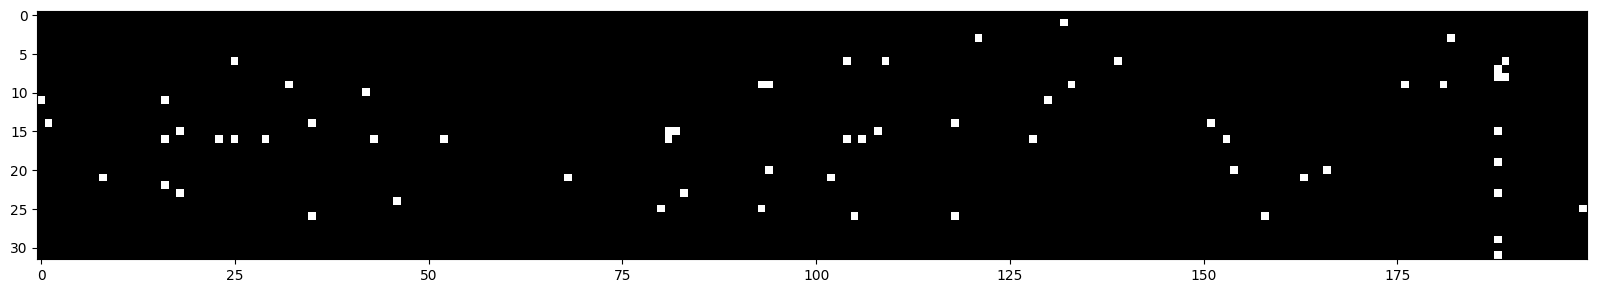

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# h.abs() > 0.99 is boolean tensor
# shows 'white is true, black is false'
# image shows h, which has 32 examples and 200 hidden neurons.

# white parts neurons are in a flat tail. all these cases backward gradient would get destroyed.

# we would be in a lot of trouble, for any one of these 200 neurons, if it was the case that entire column is white, because in that casese we have what's called a dead neuron. 

### Then, How we solve this problem?

-> modify hpreact

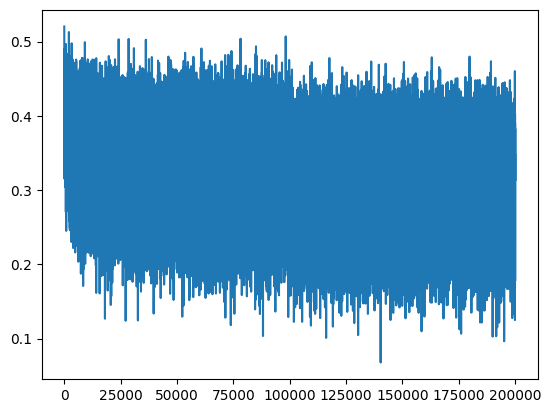

In [28]:
plt.plot(lossi)

In [51]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
bnmean

In [ ]:
bnmean_running

In [55]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.078073024749756
val 2.1128153800964355


아래 코드는,
1. 모델이 예측한 확률 분포(Probability Distribution)을 얻어내고,
2. 그 분포로부터 가장 가능성 높은 것을 확률에 따라 뽑기(Sampling)하고,
3. 뽑힌 결과를 다음 예측의 입력으로 다시 사용하여, 한 글자씩 단어를 '조립'하는 과정과 같다. 

In [16]:
# sample from the model
g = torch.Generator().manual_seed(seed_num + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)  # probabilities of next character 
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
nah.
yal.
renyra.
endrael.
adeeroselin.
shy.
jenne.
elisson.
artelyn.
malkia.
noshubergahimies.
kendreelle.
jose.
casu.
zen.
der.
yarleyeks.


In [17]:
probs.shape

torch.Size([1, 27])